In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
N = 100
K = 23
n = 19
ks = np.arange(12)
ps = ss.hypergeom(N, K, n).pmf(ks)

In [3]:
def make_uniform(qs, name=None, **options):
    pmf = Pmf(1.0, qs, **options)
    pmf.normalize()
    if name:
        pmf.index.name = name
    return pmf

In [4]:
qs = np.arange(50, 501)
prior_N = make_uniform(qs, name='N')

In [5]:
Ns = prior_N.qs
K = 23
n = 19
k = 4

In [6]:
likelihood = ss.hypergeom(Ns, K, n).pmf(k)

In [7]:
posterior_N = prior_N * likelihood
posterior_N.normalize()

0.07755224277106727

In [8]:
N = 100
k10 = 23 - 4
k01 = 19 - 4
k11 = 4
observed = k01 + k10 + k11
k00 = N - observed
x = [k00, k01, k10, k11]

In [9]:
p = 0.2
q = 1 - p
y = [q*q, q*p, p*q, p*p]

In [10]:
likelihood = ss.multinomial.pmf(x, N, y)

In [11]:
ss.multinomial.pmf(x, N, y) == ss.multinomial(N, y).pmf(x)

True

In [12]:
qs = np.linspace(0, 0.99, 100)
prior_p = make_uniform(qs, name='p')

In [13]:
def make_joint(pmf1, pmf2):
    X, Y = np.meshgrid(pmf1, pmf2)
    return pd.DataFrame(X * Y, columns=pmf1.qs, index=pmf2.qs)

In [14]:
joint_prior = make_joint(prior_p, prior_N)
joint_prior.shape

(451, 100)

In [15]:
joint_pmf = Pmf(joint_prior.stack())
joint_pmf.head(), len(joint_pmf)

(50  0.00    0.000022
     0.01    0.000022
     0.02    0.000022
 Name: , dtype: float64,
 45100)

In [16]:
likelihood = joint_pmf.copy()

In [17]:
for N, p in joint_pmf.index:
    k00 = N - observed
    x = [k00, k01, k10, k11]
    q = 1 - p
    y = [q*q, q*p, p*q, p*p]
    likelihood[N, p] = ss.multinomial.pmf(x, N, y)

In [18]:
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

2.9678796190279657e-05

In [19]:
def plot_contour(joint):
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.contour(joint.columns, joint.index, joint, linewidths=2)

In [20]:
joint_posterior = posterior_pmf.unstack()

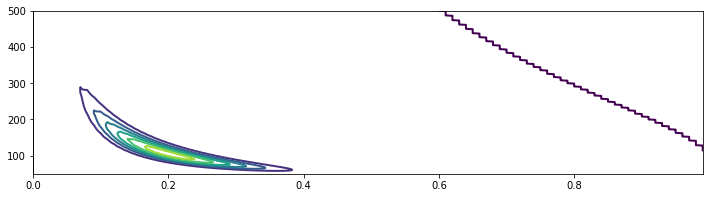

In [21]:
plot_contour(joint_posterior)

In [22]:
k10 = 20 - 3
k01 = 15 - 3
k11 = 3
observed = k10 + k01 + k11

In [23]:
p0, p1 = 0.2, 0.15

In [24]:
def compute_probs(p0, p1):
    q0 = 1 - p0
    q1 = 1 - p1
    return [q0*q1, q0*p1, q1*p0, p0*p1]

In [25]:
y = compute_probs(p0, p1)
y

[0.68, 0.12, 0.17, 0.03]

In [26]:
qs = np.arange(32, 350, step=5)
prior_N = make_uniform(qs, name='N')
prior_N.head()

,probs
N,
32,0.015625
37,0.015625
42,0.015625


In [27]:
data = np.array([0, k01, k10, k11])

In [28]:
likelihood = prior_N.copy()
observed = data.sum()
x = data.copy()

In [29]:
for N in prior_N.qs:
    x[0] = N - observed
    likelihood[N] = ss.multinomial.pmf(x, N, y)

In [30]:
qs = np.linspace(0, 1, 51)
prior_p0 = make_uniform(qs, name='p0')
prior_p1 = make_uniform(qs, name='p1')

In [31]:
joint2 = make_joint(prior_p0, prior_N)
joint2_pmf = Pmf(joint2.stack())

In [32]:
joint3 = make_joint(prior_p1, joint2_pmf)
joint3.index = pd.MultiIndex.from_tuples(joint3.index)
joint3_pmf = Pmf(joint3.stack())

In [33]:
joint3_pmf.shape

(166464,)

In [34]:
likelihood = joint3_pmf.copy()
observed = data.sum()
x = data.copy()

In [35]:
for N, p0, p1 in joint3_pmf.index:
    x[0] = N - observed
    y = compute_probs(p0, p1)
    likelihood[N, p0, p1] = ss.multinomial.pmf(x, N, y)

In [36]:
posterior_pmf = joint3_pmf * likelihood
posterior_pmf.normalize()

8.941088283758206e-06

In [37]:
posterior_pmf.marginal(0)

,probs
32,0.000003
37,0.000876
42,0.006787
47,0.019222
52,0.034346
...,...
327,0.000733
332,0.000687
337,0.000644
342,0.000604
